In [17]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import timedelta

In [18]:
#Read Data
df = pd.read_csv("Final.csv")          
print(df.head(10))

    Country     Region        Date   AQI  Temperature  RelativeHumidity  \
0  Malaysia  AlorSetar  2014-01-01  34.0        26.11             76.95   
1  Malaysia  AlorSetar  2014-01-02  30.0        26.48             77.45   
2  Malaysia  AlorSetar  2014-01-03  28.0        26.40             78.64   
3  Malaysia  AlorSetar  2014-01-04  32.0        26.38             79.88   
4  Malaysia  AlorSetar  2014-01-05  37.0        26.32             77.90   
5  Malaysia  AlorSetar  2014-01-06  31.0        26.16             81.93   
6  Malaysia  AlorSetar  2014-01-07  30.0        26.37             75.62   
7  Malaysia  AlorSetar  2014-01-08  41.0        26.29             74.69   
8  Malaysia  AlorSetar  2014-01-09  40.0        25.68             79.88   
9  Malaysia  AlorSetar  2014-01-10  22.0        25.33             78.87   

   WindSpeed  
0      21.52  
1      20.62  
2      17.37  
3      15.41  
4      14.90  
5      11.99  
6      15.98  
7      19.16  
8      21.09  
9      19.84  


In [19]:

# Check and Clean Missing Values
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Convert to numeric
for col in ['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing AQI with mean
df['AQI'] = df['AQI'].fillna(df['AQI'].mean())

print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values before cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64

Missing values after cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64


In [20]:
# Convert date column and prepare countries list
df['Date'] = pd.to_datetime(df['Date'])

# Process Each Country variables
countries = df['Country'].unique()
print("Countries to process:", countries)


Countries to process: ['Malaysia' 'Singapore' 'Thailand']


Processing Country: Malaysia

Model Performance on Test Set:
R²: 0.598
MAE: 8.552
RMSE: 11.177

Predicted AQI for Malaysia (Next 6 Months):
        Date  Predicted_AQI
0 2024-12-30      34.735378
1 2024-12-31      35.524448
2 2025-01-01      39.371216
3 2025-01-02      32.635639
4 2025-01-03      36.859783
5 2025-01-04      40.734077
6 2025-01-05      33.519005
7 2025-01-06      39.375984
8 2025-01-07      37.168999
9 2025-01-08      39.617851
...


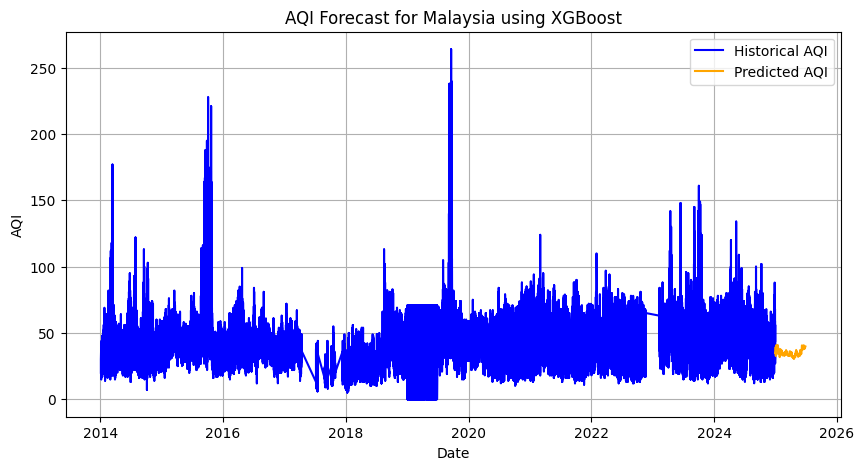

Processing Country: Singapore

Model Performance on Test Set:
R²: 0.744
MAE: 5.238
RMSE: 6.513

Predicted AQI for Singapore (Next 6 Months):
        Date  Predicted_AQI
0 2024-01-01      40.676819
1 2024-01-02      39.917683
2 2024-01-03      39.073250
3 2024-01-04      39.059860
4 2024-01-05      39.762215
5 2024-01-06      35.263176
6 2024-01-07      40.110741
7 2024-01-08      36.871433
8 2024-01-09      38.240204
9 2024-01-10      38.160873
...


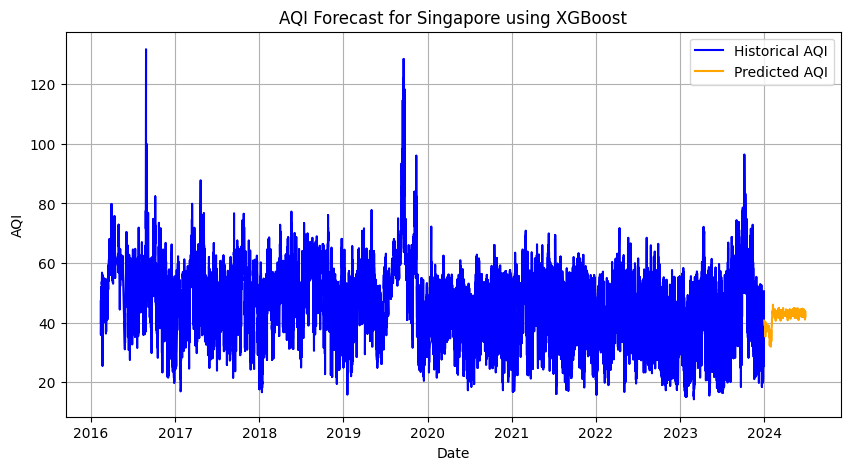

Processing Country: Thailand

Model Performance on Test Set:
R²: 0.701
MAE: 12.022
RMSE: 17.760

Predicted AQI for Thailand (Next 6 Months):
        Date  Predicted_AQI
0 2025-01-01     118.254158
1 2025-01-02      59.170815
2 2025-01-03      85.162590
3 2025-01-04      95.879120
4 2025-01-05      84.885010
5 2025-01-06     100.490326
6 2025-01-07     104.778839
7 2025-01-08     103.276360
8 2025-01-09     127.540550
9 2025-01-10     117.514305
...


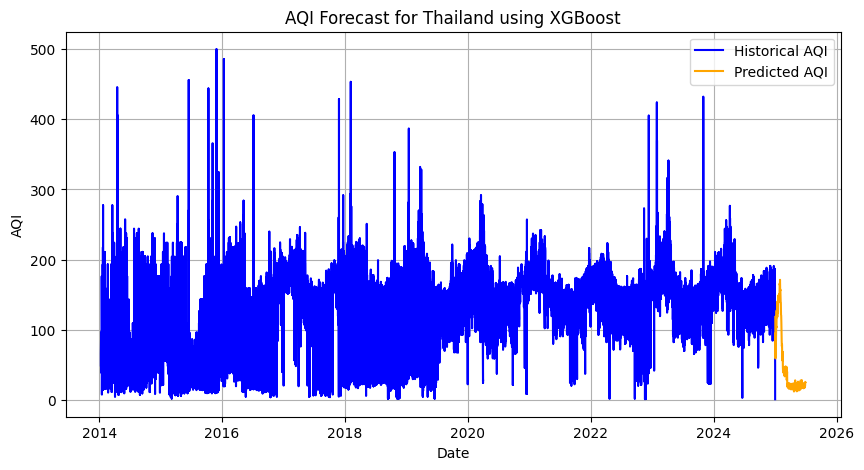

In [21]:
# Cell 6: Process Each Country
for country in countries:
    print("=" * 60)
    print(f"Processing Country: {country}")
    print("=" * 60)

    country_data = df[df['Country'] == country].sort_values('Date').copy()

    # -------------------------------
    # Feature Engineering
    # -------------------------------
    country_data['month'] = country_data['Date'].dt.month
    country_data['day'] = country_data['Date'].dt.day
    country_data['dayofweek'] = country_data['Date'].dt.dayofweek
    country_data['year'] = country_data['Date'].dt.year

    # Lag features
    for lag in [1, 3, 7, 14, 30]:
        country_data[f'aqi_lag_{lag}'] = country_data['AQI'].shift(lag)

    # Rolling mean features
    country_data['aqi_roll_3'] = country_data['AQI'].rolling(3).mean()
    country_data['aqi_roll_7'] = country_data['AQI'].rolling(7).mean()
    country_data['aqi_roll_14'] = country_data['AQI'].rolling(14).mean()

    # Seasonality encoding (cyclical)
    country_data['month_sin'] = np.sin(2 * np.pi * country_data['month'] / 12)
    country_data['month_cos'] = np.cos(2 * np.pi * country_data['month'] / 12)
    country_data['dayofweek_sin'] = np.sin(2 * np.pi * country_data['dayofweek'] / 7)
    country_data['dayofweek_cos'] = np.cos(2 * np.pi * country_data['dayofweek'] / 7)

    # Drop missing after lag/rolling creation
    country_data = country_data.dropna()

    # -------------------------------
    # Define Features and Target
    # -------------------------------
    features = [
        'Temperature', 'RelativeHumidity', 'WindSpeed',
        'month', 'day', 'dayofweek',
        'aqi_lag_1', 'aqi_lag_3', 'aqi_lag_7', 'aqi_lag_14', 'aqi_lag_30',
        'aqi_roll_3', 'aqi_roll_7', 'aqi_roll_14',
        'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos'
    ]

    X = country_data[features]
    y = country_data['AQI']

    # Split chronologically (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # -------------------------------
    # Train XGBoost Model
    # -------------------------------
    model = XGBRegressor(
        n_estimators=600,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    )

    model.fit(X_train, y_train)

    # -------------------------------
    # Evaluate Model
    # -------------------------------
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("\nModel Performance on Test Set:")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # -------------------------------
    # Forecast Next 6 Months
    # -------------------------------
    last_known = country_data.iloc[-30:].copy()
    future_dates = pd.date_range(start=country_data['Date'].max() + timedelta(days=1), periods=180)

    predictions = []
    for next_date in future_dates:
        # Prepare next input
        next_row = {
            'Temperature': last_known['Temperature'].mean(),
            'RelativeHumidity': last_known['RelativeHumidity'].mean(),
            'WindSpeed': last_known['WindSpeed'].mean(),
            'month': next_date.month,
            'day': next_date.day,
            'dayofweek': next_date.dayofweek,
            'aqi_lag_1': last_known['AQI'].iloc[-1],
            'aqi_lag_3': last_known['AQI'].iloc[-3],
            'aqi_lag_7': last_known['AQI'].iloc[-7],
            'aqi_lag_14': last_known['AQI'].iloc[-14],
            'aqi_lag_30': last_known['AQI'].iloc[-30],
            'aqi_roll_3': last_known['AQI'].iloc[-3:].mean(),
            'aqi_roll_7': last_known['AQI'].iloc[-7:].mean(),
            'aqi_roll_14': last_known['AQI'].iloc[-14:].mean(),
            'month_sin': np.sin(2 * np.pi * next_date.month / 12),
            'month_cos': np.cos(2 * np.pi * next_date.month / 12),
            'dayofweek_sin': np.sin(2 * np.pi * next_date.dayofweek / 7),
            'dayofweek_cos': np.cos(2 * np.pi * next_date.dayofweek / 7)
        }

        next_pred = model.predict(pd.DataFrame([next_row]))[0]
        predictions.append(next_pred)

        # Add prediction for future lags
        new_row = pd.DataFrame({'Date': [next_date], 'AQI': [next_pred]})
        last_known = pd.concat([last_known, new_row]).iloc[1:].reset_index(drop=True)

    future_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_AQI': predictions
    })

    print(f"Predicted AQI for {country} (Next 6 Months):")
    print(future_df.head(10))
    print("...")

    # -------------------------------
    # Visualization
    # -------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(country_data['Date'], country_data['AQI'], label='Historical AQI', color='blue')
    plt.plot(future_df['Date'], future_df['Predicted_AQI'], label='Predicted AQI', color='orange')
    plt.title(f"AQI Forecast for {country} using XGBoost")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)
    plt.show()
